In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import pandas as pd

# HELPERS

In [2]:
def write_yaml_file(file, data):
    with open(file, "w") as f:
        f.writelines(x + '\n' for x in data)

In [3]:
def load_pkl_dict(filename, folder):
    with open(folder + filename, "rb") as f:
        loaded_file = pickle.load(f)
        df = pd.DataFrame.from_dict(loaded_file, orient='columns')
        return df

In [4]:
def plot_df(dfp, title, labels=None, combine=False):
    fig, axs = plt.subplots(1,1)

    axs.title.set_text(f"{title}")
    axs.set_xlabel('FPR')
    axs.set_ylabel('CCR')
    axs.grid()
    axs.set_xscale('log')
    # axs[row][col].set_xlim([0, 1])  # sets the x-axis limits
    axs.set_ylim([0, 1]) # sets the y-axis limits
    axs.set_xlim(8 * 1e-5, 1.4)
    
    if labels is None:
        for index, row in dfp.iterrows():
            axs.plot(row['FPR'], row['CCR'], label=f"$\\alpha$: {row['ALPHA']},  $\eta$: {row['TAILSIZE']},  $\kappa$: {row['DIST_MULT']}")
    elif labels is not None and combine:
        counter = 0
        for index, row in dfp.iterrows():
            axs.plot(row['FPR'], row['CCR'], label=f"{labels[counter]}: $\\alpha$: {row['ALPHA']},  $\eta$: {row['TAILSIZE']},  $\kappa$: {row['DIST_MULT']}")
            counter += 1
        
    else:
        counter = 0
        for index, row in dfp.iterrows():
            axs.plot(row['FPR'], row['CCR'], label=labels[counter])
            counter += 1
    
        
    axs.legend(loc="upper left") 
    plt.savefig(f"output/{title}.png")
    plt.show()

In [5]:
def plot_df_double(dfp, dfp1, title, label):
    fig, axs = plt.subplots(1,1)

    axs.title.set_text(f"{title}")
    axs.set_xlabel('FPR')
    axs.set_ylabel('CCR')
    axs.grid()
    axs.set_xscale('log')
    # axs[row][col].set_xlim([0, 1])  # sets the x-axis limits
    axs.set_ylim([0, 1]) # sets the y-axis limits
    axs.set_xlim(8 * 1e-4, 1.4)
    
    for index, row in dfp.iterrows():
        axs.plot(row['FPR'], row['CCR'], label=f"{row[f'{label}']}")
        
    for index, row in dfp1.iterrows():
        axs.plot(row['FPR'], row['CCR'], label=f"{row[f'{label}']}")
    
        
    axs.legend(loc="upper left")   
    plt.show()

In [6]:
def oscr_epsilon_ccr_at_fpr(ccr, fpr, fpr_thresholds):
    threshold_values = []
    for threshold in fpr_thresholds:
        idx = np.where(fpr == threshold)
        value = ccr[idx]
        if value.shape[0] == 0:
            value = np.append(value, 0.0)
        threshold_values.append((threshold, value))
    epsilon_score = np.sum([t[1] for t in threshold_values])
    return epsilon_score, threshold_values

In [7]:
def ranking_scores_base(alphas, norms, neg_fix, input_cluster, feature_cluster, types, dataset):
    folder = "../experiment_data/condensed/base/emnist/"
    dfs = []
    for t in types:
        for alpha in alphas:
            for norm in norms:
                for fix in neg_fix:
                    for ic in input_cluster:
                        for fc in feature_cluster:
                            df = load_pkl_dict(f"oscr_data_{t}_{dataset}_{ic}_{fc}_{alpha}_{fix}_{norm}.pkl", folder)
                            df['TYPE'] = t
                            df['ALPHA'] = alpha
                            df['NORM'] = norm
                            df['NEGATIVE_FIX'] = fix
                            df['INPUT-CLUSTER'] = ic
                            df['FEATURES-CLUSTER'] = fc
                            df['GAMMA+'] = df['GAMMA'].apply(lambda x: x[1])
                            df['GAMMA-'] = df['GAMMA'].apply(lambda x: x[2])
                            df['GAMMA_TOTAL'] = df['GAMMA'].apply(lambda x: x[0])
                            df['EPSILON_TOTAL'] = df['EPSILON'].apply(lambda x: x[0])
                            df['CCR'] = df['CCR-FPR'].apply(lambda x: x[0])
                            df['FPR'] = df['CCR-FPR'].apply(lambda x: x[1])
                            
                    dfs.append(df)
    df_final = pd.concat(dfs)
    return df_final

In [8]:
def recalc_epsilon(row, thresholds):
    return oscr_epsilon_ccr_at_fpr(row['CCR'], row['FPR'], thresholds)[0]

In [9]:
def ranking_scores_cluster(alphas, norm, fix, types):
    folder = "../experiment_data/condensed/clusters/emnist/"
    dfs = []
    for t in types:
        for a in alphas:
            df = load_pkl_dict(f"oscr_data_{t}_{a}.pkl", folder)
            df['TYPE'] = t
            df['ALPHA'] = a
            df['NORM'] = norm[0]
            df['NEGATIVE_FIX'] = fix
            df['GAMMA+'] = df['GAMMA'].apply(lambda x: x[1])
            df['GAMMA-'] = df['GAMMA'].apply(lambda x: x[2])
            df['GAMMA_TOTAL'] = df['GAMMA'].apply(lambda x: x[0])
            df['EPSILON_TOTAL'] = df['EPSILON'].apply(lambda x: x[0])
            df['CCR'] = df['CCR-FPR'].apply(lambda x: x[0])
            df['FPR'] = df['CCR-FPR'].apply(lambda x: x[1])
            dfs.append(df)
    df_final = pd.concat(dfs)
    return df_final

In [10]:
alphas = [-1, 3, 5, 7, 10]
norms = ["NONE", "WEIGHTS", "N-CLASSES"]
neg_fixes = ["ORIGINAL", "VALUE_SHIFT", "ADJUSTED_NEGATIVE_VALUE"]
types = ["base", "input-cluster", "validation-features-cluster", "training-features-cluster", "input-training-features-cluster", "input-validation-features-cluster"]
input_cluster = [1]
feature_cluster = [1]
df = ranking_scores_base(alphas, norms, neg_fixes, input_cluster, feature_cluster, types[:1], "EMNIST")

In [11]:
alphas = [3, 5, 7, 10]
norms = ["NONE"]
f = "NONE"
types = ["input-cluster", "validation-features-cluster", "training-features-cluster", "input-training-features-cluster", "input-validation-features-cluster"]
dfc = ranking_scores_cluster(alphas, norms, f, types)

In [12]:
df = pd.concat([df, dfc])
df = df.reset_index()
df = df.rename(columns={'index': 'TAIL-DIST_MULT'})
df[['TAILSIZE', 'DIST_MULT', 'INPUT-CLUSTER', 'FEATURES-CLUSTER']] = df['TAIL-DIST_MULT'].str.extract(r'(\d+)-(-?\d+.\d+)-(\d+)-(\d+)')

In [13]:
df['TAILSIZE'] = df['TAILSIZE'].astype(int)
#df = df.loc[df['TAILSIZE'] <= 1000]

In [14]:
thresholds = [0.1, 0.2, 0.5, 0.7, 1.0]
df['EPSILON_TOTAL'] = df.apply(recalc_epsilon, axis=1, thresholds=thresholds)

# PLOTS

# Experiment 1

In [15]:
table_titles = ["ALPHA", "TAILSIZE", "DIST_MULT", "NORM", "NEGATIVE_FIX","GAMMA+", "GAMMA-", "GAMMA_TOTAL", "EPSILON_TOTAL"]

### BASELINE

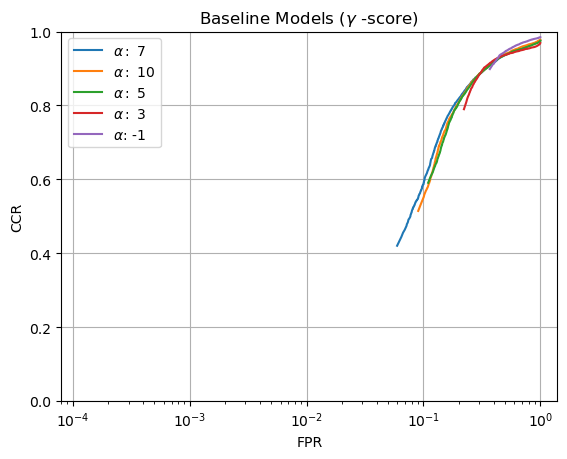

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL
1336,7,1000,1.0,NONE,ORIGINAL,0.779513,0.831009,0.805261,4.2722
1768,10,1000,1.0,NONE,ORIGINAL,0.809906,0.797581,0.803743,3.6851
904,5,1000,1.0,NONE,ORIGINAL,0.855399,0.745505,0.800452,3.6695
472,3,1000,1.0,NONE,ORIGINAL,0.935883,0.501926,0.718904,2.8555
40,-1,1000,1.0,NONE,ORIGINAL,0.974098,0.227364,0.600731,2.8995


In [16]:
query = "NEGATIVE_FIX == 'ORIGINAL' and NORM  == 'NONE' and TYPE == 'base'"

df_exp1_base = df.query(query)

exp1_gamma = df_exp1_base.nlargest(1000, 'GAMMA_TOTAL').drop_duplicates(subset=['ALPHA'], keep="first")

plot_df(exp1_gamma, "Baseline Models ($\gamma$ -score)",["$\\alpha:$ 7", "$\\alpha:$ 10", "$\\alpha:$ 5","$\\alpha:$ 3","$\\alpha$: -1"])
exp1_gamma[table_titles].to_latex('mytable-gamma.tex')
exp1_gamma[table_titles]

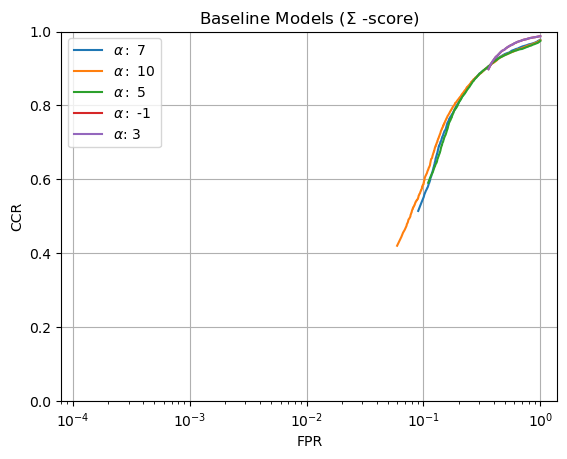

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL
1336,7,1000,1.0,NONE,ORIGINAL,0.779513,0.831009,0.805261,4.2722
1768,10,1000,1.0,NONE,ORIGINAL,0.809906,0.797581,0.803743,3.6851
904,5,1000,1.0,NONE,ORIGINAL,0.855399,0.745505,0.800452,3.6695
5,-1,10,2.3,NONE,ORIGINAL,0.987287,0.041875,0.514581,2.9170
446,3,100,3.0,NONE,ORIGINAL,0.987272,0.042286,0.514779,2.9163


In [17]:
exp1_eps = df_exp1_base.nlargest(1000, 'EPSILON_TOTAL').drop_duplicates(subset=['ALPHA'], keep="first")
plot_df(exp1_eps.sort_values("ALPHA", ascending=False), "Baseline Models ($ \Sigma$ -score)", ["$\\alpha:$ 7", "$\\alpha:$ 10", "$\\alpha:$ 5","$\\alpha:$ -1","$\\alpha$: 3"])
exp1_eps[table_titles].to_latex('mytable-eps.tex')
exp1_eps[table_titles]

# Top Scoring Baseline

### NEGATIVE_FIX

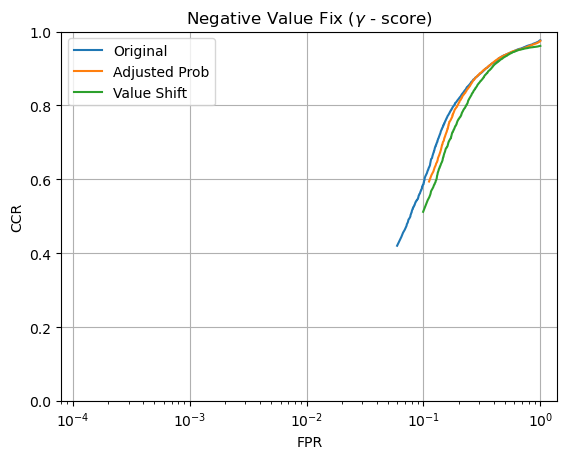

In [18]:
query = "NORM  == 'NONE' and TYPE == 'base'"

exp1_nf = df.query(query)
exp1_gamma_nf = exp1_nf.nlargest(100, 'GAMMA_TOTAL').drop_duplicates(subset=['NEGATIVE_FIX'], keep="first")


plot_df(exp1_gamma_nf, "Negative Value Fix ($\gamma$ - score)",["Original", "Adjusted Prob", "Value Shift"])
exp1_gamma_nf 
exp1_gamma_nf[table_titles].round(3).to_latex('neg-fix-gamma.tex')

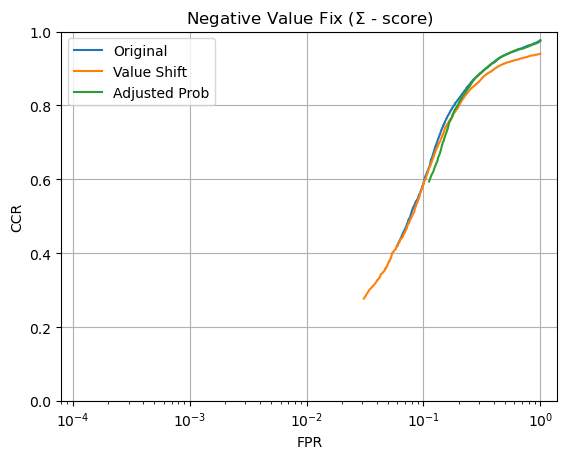

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL
1336,7,1000,1.0,NONE,ORIGINAL,0.779513,0.831009,0.805261,4.2722
952,5,1000,1.0,NONE,VALUE_SHIFT,0.603548,0.894999,0.749274,4.1693
1000,5,1000,1.0,NONE,ADJUSTED_NEGATIVE_VALUE,0.857346,0.744060,0.800703,3.6708


In [19]:
exp1_eps_nf = exp1_nf.nlargest(100, 'EPSILON_TOTAL').drop_duplicates(subset=['NEGATIVE_FIX'], keep="first")


plot_df(exp1_eps_nf, "Negative Value Fix ($\Sigma$ - score)", ["Original", "Value Shift", "Adjusted Prob"])
exp1_eps_nf 
exp1_eps_nf[table_titles].round(3).to_latex('neg-fix-eps.tex')
exp1_eps_nf[table_titles]

### NORM

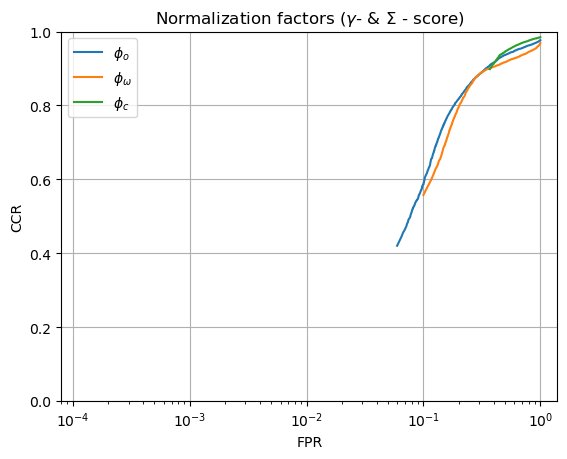

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL
1336,7,1000,1.0,NONE,ORIGINAL,0.779513,0.831009,0.805261,4.2722
616,3,1000,1.0,WEIGHTS,ORIGINAL,0.874953,0.709038,0.791995,4.1761
328,-1,1000,1.0,N-CLASSES,ORIGINAL,0.974252,0.226153,0.600202,2.8994


In [20]:
query = "NEGATIVE_FIX  == 'ORIGINAL' and TYPE == 'base'"

exp1_gamma_norm = df.query(query)
exp1_gamma_norm = exp1_gamma_norm.nlargest(1000, 'GAMMA_TOTAL').drop_duplicates(subset=['NORM'], keep="first")


plot_df(exp1_gamma_norm, "Normalization factors ($\gamma$- & $\Sigma$ - score)", ["$\phi_o$", "$\phi_\omega$", "$\phi_c$" ])
exp1_gamma_norm[table_titles].round(3).to_latex('norm-fix-gamma.tex')
exp1_gamma_norm[table_titles]

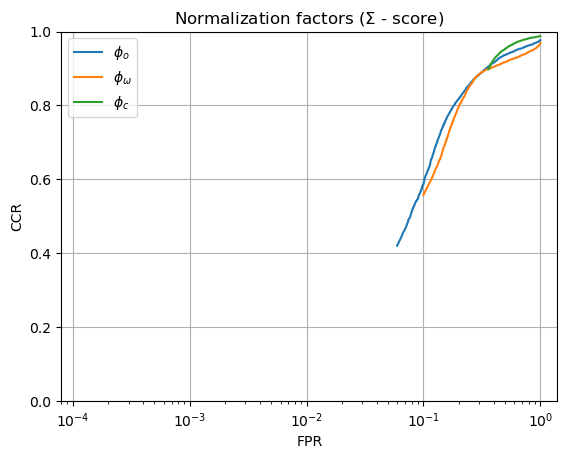

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL
1336,7,1000,1.0,NONE,ORIGINAL,0.779513,0.831009,0.805261,4.2722
616,3,1000,1.0,WEIGHTS,ORIGINAL,0.874953,0.709038,0.791995,4.1761
2021,10,10,2.3,N-CLASSES,ORIGINAL,0.987288,0.041884,0.514586,2.9170


In [21]:
query = "NEGATIVE_FIX  == 'ORIGINAL' and TYPE == 'base'"

exp1_eps_norm = df.query(query)
exp1_eps_norm = exp1_eps_norm.nlargest(1000, 'EPSILON_TOTAL').drop_duplicates(subset=['NORM'], keep="first")


plot_df(exp1_eps_norm, "Normalization factors ($\Sigma$ - score)", ["$\phi_o$", "$\phi_\omega$", "$\phi_c$" ])
exp1_eps_norm
exp1_eps_norm[table_titles].round(3).to_latex('norm-fix-eps.tex')
exp1_eps_norm[table_titles]

### All combined

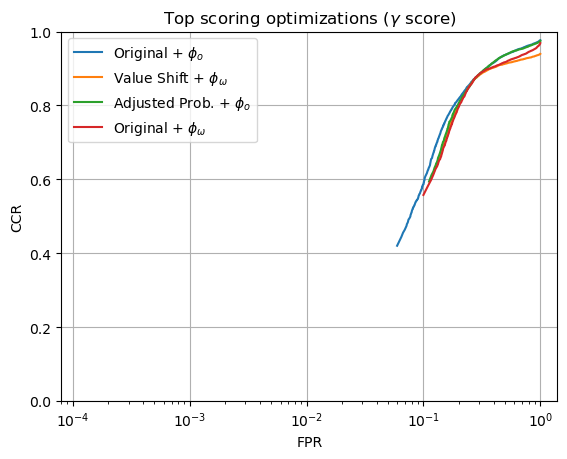

In [22]:
query = "TYPE == 'base'"

exp1_combined = df.query(query)
exp1_gamma_combined = exp1_combined.nlargest(14, 'GAMMA_TOTAL').drop_duplicates(subset=['NORM', 'NEGATIVE_FIX'], keep="first")


plot_df(exp1_gamma_combined, "Top scoring optimizations ($\gamma$ score)", ["Original + $\phi_o$", "Value Shift + $\phi_\omega$", "Adjusted Prob. + $\phi_o$", "Original + $\phi_\omega$"])
exp1_gamma_combined
exp1_gamma_combined[table_titles].round(3).to_latex('all-gamma.tex')

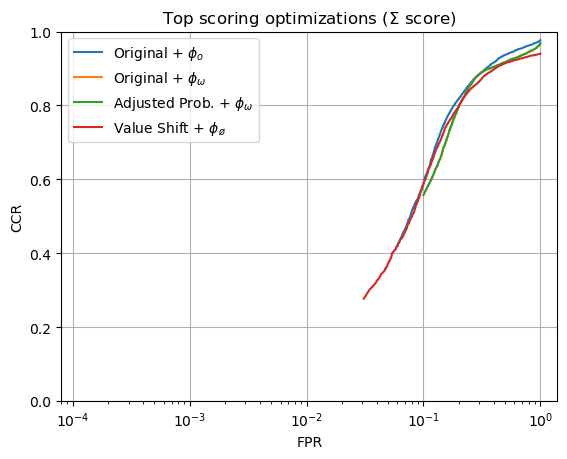

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL
1336,7,1000,1.0,NONE,ORIGINAL,0.780,0.831,0.805,4.272
616,3,1000,1.0,WEIGHTS,ORIGINAL,0.875,0.709,0.792,4.176
712,3,1000,1.0,WEIGHTS,ADJUSTED_NEGATIVE_VALUE,0.875,0.709,0.792,4.176
952,5,1000,1.0,NONE,VALUE_SHIFT,0.604,0.895,0.749,4.169


In [23]:
exp1_eps_combined = exp1_combined.nlargest(5, 'EPSILON_TOTAL').drop_duplicates(subset=['NORM', 'NEGATIVE_FIX'], keep="first")


plot_df(exp1_eps_combined, "Top scoring optimizations ($\Sigma$ score)", ["Original + $\phi_o$", "Original + $\phi_\omega$", "Adjusted Prob. + $\phi_\omega$", "Value Shift + $\phi_\o$"])
exp1_eps_combined
exp1_eps_combined[table_titles].round(3)

# Exp 2 + 3

### CLUSTER VS NON-CLUSTER

In [24]:
exp1_gamma_top = exp1_gamma_combined.nlargest(1, 'GAMMA_TOTAL').drop_duplicates(subset=['ALPHA', 'NORM', 'NEGATIVE_FIX'], keep="first")
exp1_eps_top = df.nlargest(1, 'EPSILON_TOTAL').drop_duplicates(subset=['ALPHA', 'NORM', 'NEGATIVE_FIX'], keep="first")

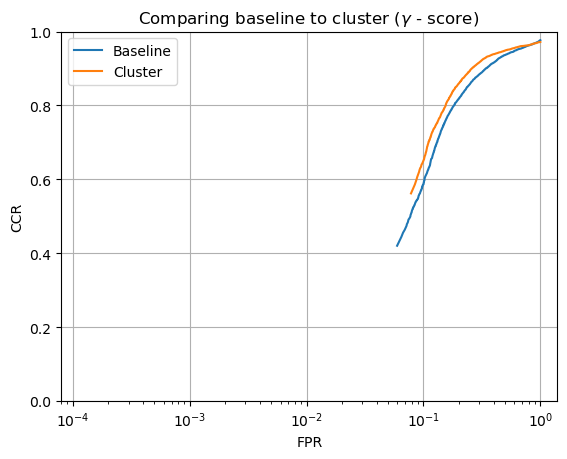

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,INPUT-CLUSTER,FEATURES-CLUSTER
1336,7,1000,1.0,NONE,ORIGINAL,0.779513,0.831009,0.805261,4.2722,1,1
6871,7,100,0.7,NONE,NONE,0.835548,0.822025,0.828786,4.3906,1,5


In [25]:
query = "TYPE == 'training-features-cluster' and ALPHA == 7"

df_exp2 = df.query(query)

exp2_gamma_top = df_exp2.nlargest(1, 'GAMMA_TOTAL')#.drop_duplicates(subset=['ALPHA'], keep="first")

df_t_gamma = pd.concat([exp1_gamma_top, exp2_gamma_top])

plot_df(df_t_gamma, "Comparing baseline to cluster ($\gamma$ - score) ", ['Baseline', 'Cluster'])
#exp2_gamma[table_titles].to_latex('mytable-gamma.tex')
df_t_gamma[table_titles].round(3).to_latex('basevsclust-gamma.tex')
cl = ["INPUT-CLUSTER", "FEATURES-CLUSTER"]
df_t_gamma[table_titles + cl]

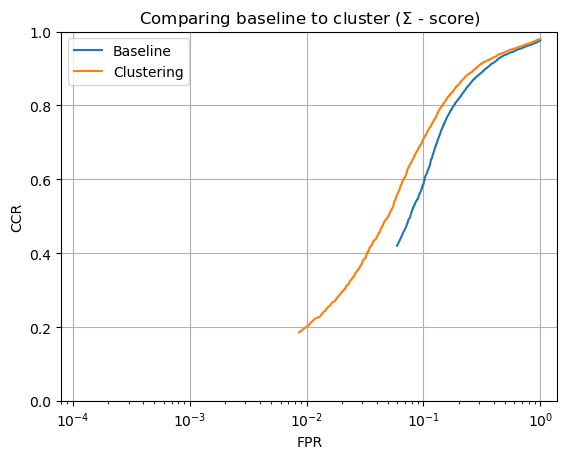

,ALPHA,TAILSIZE,DIST_MULT,NORM,NEGATIVE_FIX,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL,INPUT-CLUSTER,FEATURES-CLUSTER
1336,7,1000,1.0,NONE,ORIGINAL,0.779513,0.831009,0.805261,4.2722,1,1
7197,7,750,1.25,NONE,NONE,0.606724,0.929601,0.768163,4.4500,1,6


In [26]:
exp2_eps_top = df_exp2.nlargest(1, 'EPSILON_TOTAL')
#.drop_duplicates(subset=['ALPHA'], keep="first")

df_t_eps = pd.concat([exp1_gamma_top, exp2_eps_top])

plot_df(df_t_eps, "Comparing baseline to cluster ($\Sigma$ - score)", ['Baseline', 'Clustering'])
#exp2_gamma[table_titles].to_latex('mytable-gamma.tex')
df_t_eps[table_titles].round(3).to_latex('basevsclust-eps.tex')
df_t_eps[table_titles + cl]

Why dist-multpl -> val set -> small to negative, cluster -> dist_multp small  sizes and wide spread -> should be defined for each cluster, but we don't do that
u-map 

### Impact of Cluster Sizes

In [27]:
all_tables = ["TYPE", "ALPHA", "TAILSIZE", "DIST_MULT",  "INPUT-CLUSTER", "FEATURES-CLUSTER", "GAMMA+", "GAMMA-", "GAMMA_TOTAL", "EPSILON_TOTAL"]

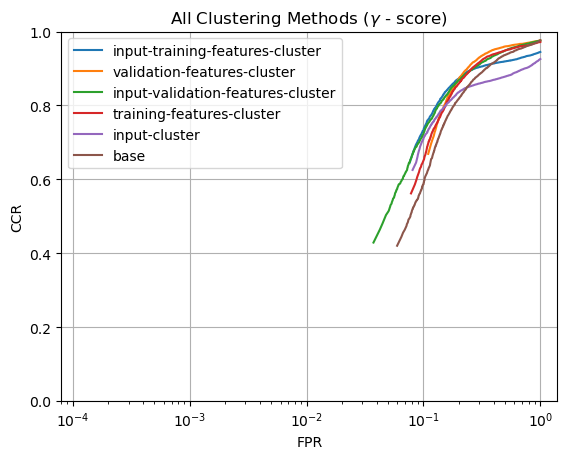

,TYPE,ALPHA,TAILSIZE,DIST_MULT,INPUT-CLUSTER,FEATURES-CLUSTER,GAMMA+,GAMMA-,GAMMA_TOTAL,EPSILON_TOTAL
12592,input-training-features-cluster,5,100,0.7,2,3,0.845,0.837,0.841,3.666
5340,validation-features-cluster,7,10,0.5,1,5,0.885,0.784,0.834,3.774
22119,input-validation-features-cluster,5,100,1.25,2,6,0.851,0.817,0.834,4.478
6871,training-features-cluster,7,100,0.7,1,5,0.836,0.822,0.829,4.391
2796,input-cluster,5,100,0.5,2,1,0.793,0.851,0.822,4.247
1336,base,7,1000,1.0,1,1,0.780,0.831,0.805,4.272


In [28]:

df_exp3 = df.copy()

exp3_gamma_top = df_exp3.nlargest(999999, 'GAMMA_TOTAL').drop_duplicates(subset=['TYPE'], keep="first")
clustering_methods = ["input-training-features-cluster", "validation-features-cluster", "input-validation-features-cluster", "training-features-cluster", "input-cluster", "base"]
plot_df(exp3_gamma_top, "All Clustering Methods ($\gamma$ - score)", clustering_methods)
#exp2_gamma[table_titles].to_latex('mytable-gamma.tex')
exp3_gamma_top[all_tables].round(3).to_latex('all-gamma.tex')
exp3_gamma_top[all_tables].round(3)

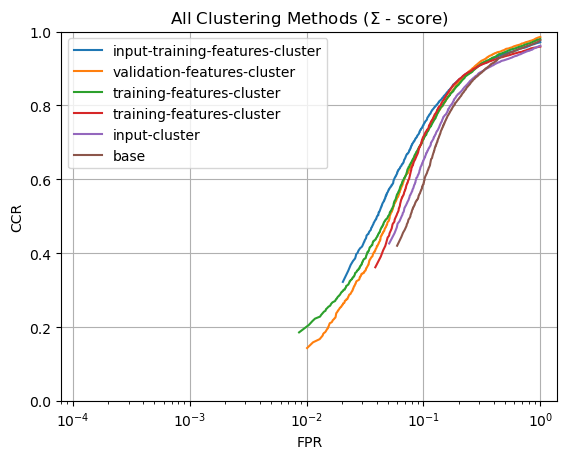

In [29]:
exp3_eps_top = df_exp3.nlargest(999999, 'EPSILON_TOTAL').drop_duplicates(subset=['TYPE'], keep="first")
clustering_methods = ["input-training-features-cluster", "validation-features-cluster", "training-features-cluster", "training-features-cluster", "input-cluster", "base"]
plot_df(exp3_eps_top, "All Clustering Methods ($\Sigma$ - score)", clustering_methods)
exp3_eps_top[all_tables].round(3).to_latex('all-eps.tex')
exp3_eps_top[all_tables].round(3)